## Tutorial: A single fine-tuned LLM can handle multiple e-commerce tasks

### Q: What is multiple e-commerce tasks?
- This large language model, fine-tuned with our domain data, can solve six tasks in e-commerce.
- The six tasks are sequence recommendation, query relationship identification, search ranking, also buy, sentiment analysis, and product title generation. 
- This tutorial teaches readers about the meaning and inference mechanism of these tasks.

In [1]:
from vllm import LLM, SamplingParams
import pandas as pd
from tqdm import tqdm
import gc
import re
import sys
import subprocess
from collections import defaultdict, Counter
import numpy as np
from transformers import (AutoModelForCausalLM,
    AutoTokenizer,
    set_seed)
import torch
import math
from IPython.display import Image

/data/ptan499/python_packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Load model
- Based on the model obtained in the storage path, the vLLM inference framework is called.

In [2]:
model_path = "./Finetuned_model"
llm = LLM(model=model_path,
          dtype='half',
          enforce_eager=True,
          gpu_memory_utilization=0.4,
          swap_space=4,
          max_model_len=4096,
          tensor_parallel_size=1)

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

INFO 06-29 12:14:14 llm_engine.py:100] Initializing an LLM engine (v0.4.2) with config: model='/data/ptan499/eCeLLM/llama3_lora_temp5', speculative_config=None, tokenizer='/data/ptan499/eCeLLM/llama3_lora_temp5', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=/data/ptan499/eCeLLM/llama3_lora_temp5)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 06-29 12:14:14 utils.py:660] Found nccl from library /home/ptan499/.config/vllm/nccl/cu12/libnccl.so.2.18.1
INFO 06-29 12:14:16 selector.py:27] Using FlashAttention-2 backend.
INFO 06-29 12:14:25 model_runner.py:175] Loading model weights took 14.9595 GB
INFO 06-29 12:14:26 gpu_executor.py:114] # GPU blocks: 7674, # CPU blocks: 2048


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Construct inference function
- Build the inference function, apply the chat template and specify stop words.

In [3]:
def get_response(system_prompt, prompt):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}]
    
    
    input_ids = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                return_tensors="pt"
            )[0].tolist()
    
    stop_words = [tokenizer.eos_token if tokenizer is not None and tokenizer.eos_token is not None else '</s>']
    stop_words.append("\n")
    
    sampling_params = SamplingParams(
                    n=1,  
                    top_p=0.9,  
                    temperature=0,  
                    seed=773815, 
                    skip_special_tokens=True,  
                    max_tokens=100,  
                )
    
    response = llm.generate(sampling_params=sampling_params, prompt_token_ids=[input_ids])
    output = response[0].outputs[0].token_ids
    generation = tokenizer.decode(output, skip_special_tokens=True)
    return generation

## Sequence recommendation example
- This task is to recommend search terms that users may enter in the future based on historical click sequences and historical search sequences. A potential application scenario is guessing what you want to search for in e-commerce.

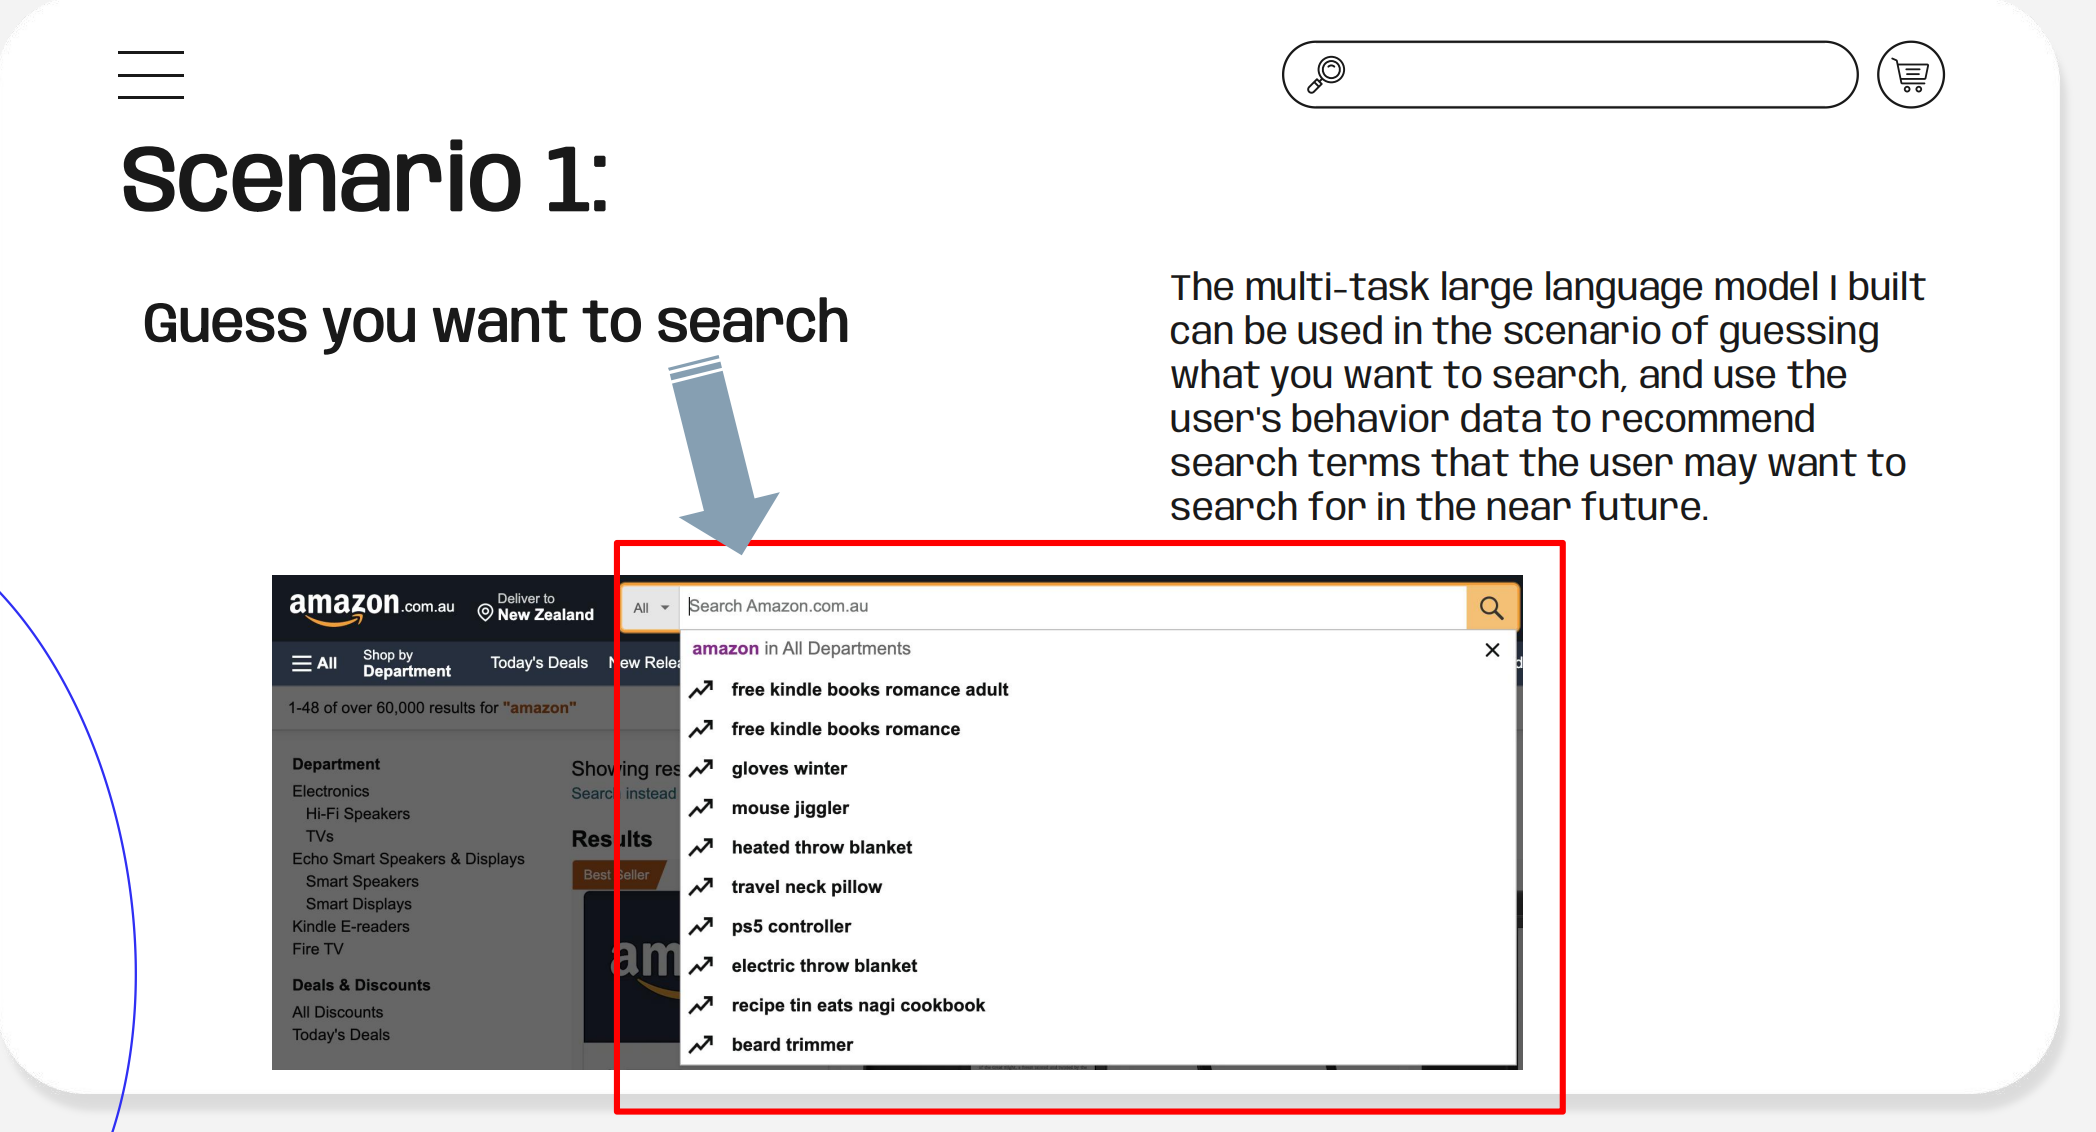

In [4]:
display(Image(filename='./Images/s1.jpg', width = 700, height = 160))

In [5]:
sequence_rec_prompt = "You are a user on an online shopping platform. You make queries and click on products to eventually find the product you want and make your purchase. \nSuppose you have just performed the following sequence of actions of queries, clicks, and purchases. What is most likely to be the keyword of your next query? \nYou are given a numbered list of ten candidate queries. Select three from the list that you think most likely. Output ONLY three numbers separated with comma. Do not give explanations. \n\nAction Sequence:\nQuery keyword 'boat cover bungee straps'\nClick on product '21 Inch Tarp Straps - Rubber Bungee Cords with Crimped S Hooks - Natural Rubber Heavy-Duty Bungee Straps - Weatherproof (Pack of 10)'\nClick on product '21 Inch Tarp Straps - Rubber Bungee Cords with Crimped S Hooks - Natural Rubber Heavy-Duty Bungee Straps - Weatherproof (Pack of 10)'\nClick on product 'Seachoice 78941 Boat Cover Tie-Down Strap Kit \u2013 Contains 12 Straps \u2013 8 Feet Long \u2013 Black'\nClick on product 'Seachoice 78941 Boat Cover Tie-Down Strap Kit \u2013 Contains 12 Straps \u2013 8 Feet Long \u2013 Black'\nClick on product 'Wake Cover Tie Down Straps - Pack of 12'\nClick on product 'Wake Cover Tie Down Straps - Pack of 12'\nQuery keyword 'pontoon cover bungee straps'\nClick on product 'Vortex New Grey 20 FT Ultra 5 Year Canvas Pontoon\/Deck Boat Cover, Elastic, Strap System, FITS 18&apos;1&quot; FT to 20&apos; Long Deck Area, UP to 102&quot; Beam (Fast - 1 to 4 Business Day DELIVERY)'\nClick on product 'Vortex New Beige 20 FT Ultra 5 Year Canvas Pontoon\/Deck Boat Cover, Elastic, Strap System, FITS 18&apos;1&quot; FT to 20&apos; Long Deck Area, UP to 102&quot; Beam (Fast - 1 to 4 Business Day DELIVERY)'\nQuery keyword 'camp quitcherbitchin rug'\nClick on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Standard Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 18 Inch x 30 Inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\nQuery keyword 'camp quitcherbitchin mat'\nClick on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Standard Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 18 Inch x 30 Inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\nClick on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Standard Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 18 Inch x 30 Inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\nQuery keyword 'camp quitcherbitchin rug'\nClick on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 23.6 inch by 15.7 inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\nQuery keyword 'camp quitcherbitchin mat'\nClick on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 23.6 inch by 15.7 inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\nClick on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 23.6 inch by 15.7 inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\nQuery keyword 'camp quitcherbitchin rug'\nFollow up click on product 'SHANGMAO Funny Camp Door Mat Entrance Floor Mat | Standard Non-Slip Back Rubber Welcome Front Doormat Outdoor Decor 18 Inch x 30 Inch | Welcome to Camp Quitcherbitchin A Certified Happy Camper Area'\n\nCandidate Query List:\n1. over the sink storage\n2. over the sink dish drying rack small\n3. smoke alarm\n4. camp quitcherbitchin mat\n5. pontoon cover bungee straps\n6. boat cover bungee straps\n7. fireplace pads for toddlers\n8. dont turn off sign\n9. Sunex impact socket set\n10. camp quitcherbitchin rug\nOutput (answer in three comma-separated numbers): "
system_prompt = 'You are an intelligent shopping assistant that can rank products based on their relevance to the query.'
get_response(system_prompt, sequence_rec_prompt)

Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


'4,7,10'

- '4,7,10' represents the recommendation of the indexes of three search terms that the user may continue to search for in the future: 4. camp quitcherbitchin mat, 7. fireplace pads for toddlers, 10. camp quitcherbitchin rug.

## Query relation example
- This task is to determine the relationship between two queries based on their semantics. There are four relationships: irrelevant, substitute, complement, and narrowing. A potential application scenario is search query completion.

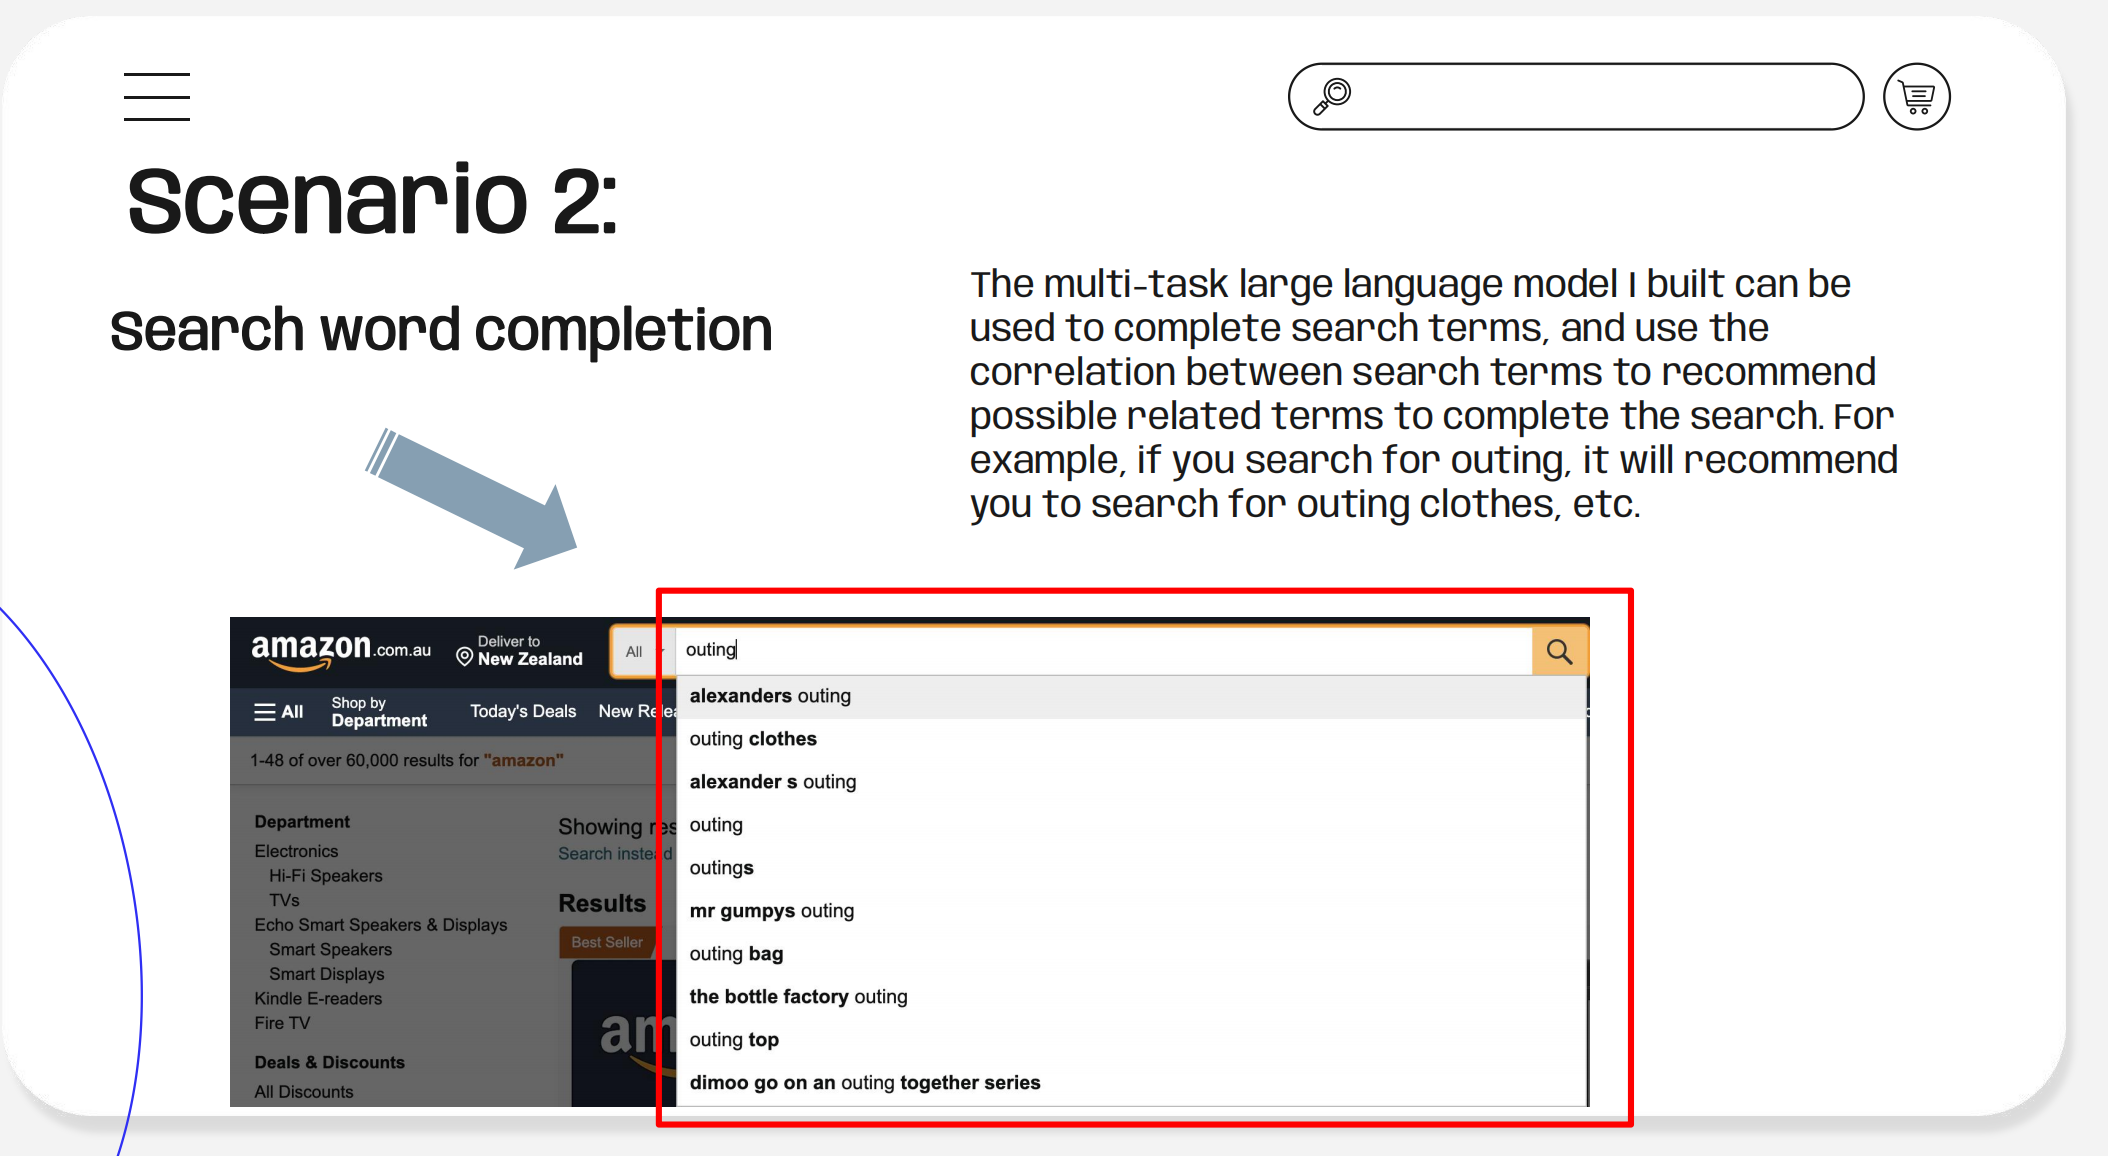

In [6]:
display(Image(filename='./Images/s2.jpg', width = 700, height = 160))

In [7]:
query_relation_prompt = "Which of the following statements best describes the relation from query \"oral b dental floss\" to query \"short sleeve polo for men\"?\n0. irrelevant\n1. substitute\n2. complement\n3. narrowing\nAnswer: "
system_prompt = 'You are an intelligent shopping assistant that can rank products based on their relevance to the query.'
get_response(system_prompt, query_relation_prompt)

Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.28it/s]


'0'

- 0 means that the two queries ("oral b dental floss" and "short sleeve polo for men") are irrelevant.

## Ranking example
- This task is to rank the candidate products into the five most relevant products based on the user's search terms. A potential application scenario is product ranking during search queries.

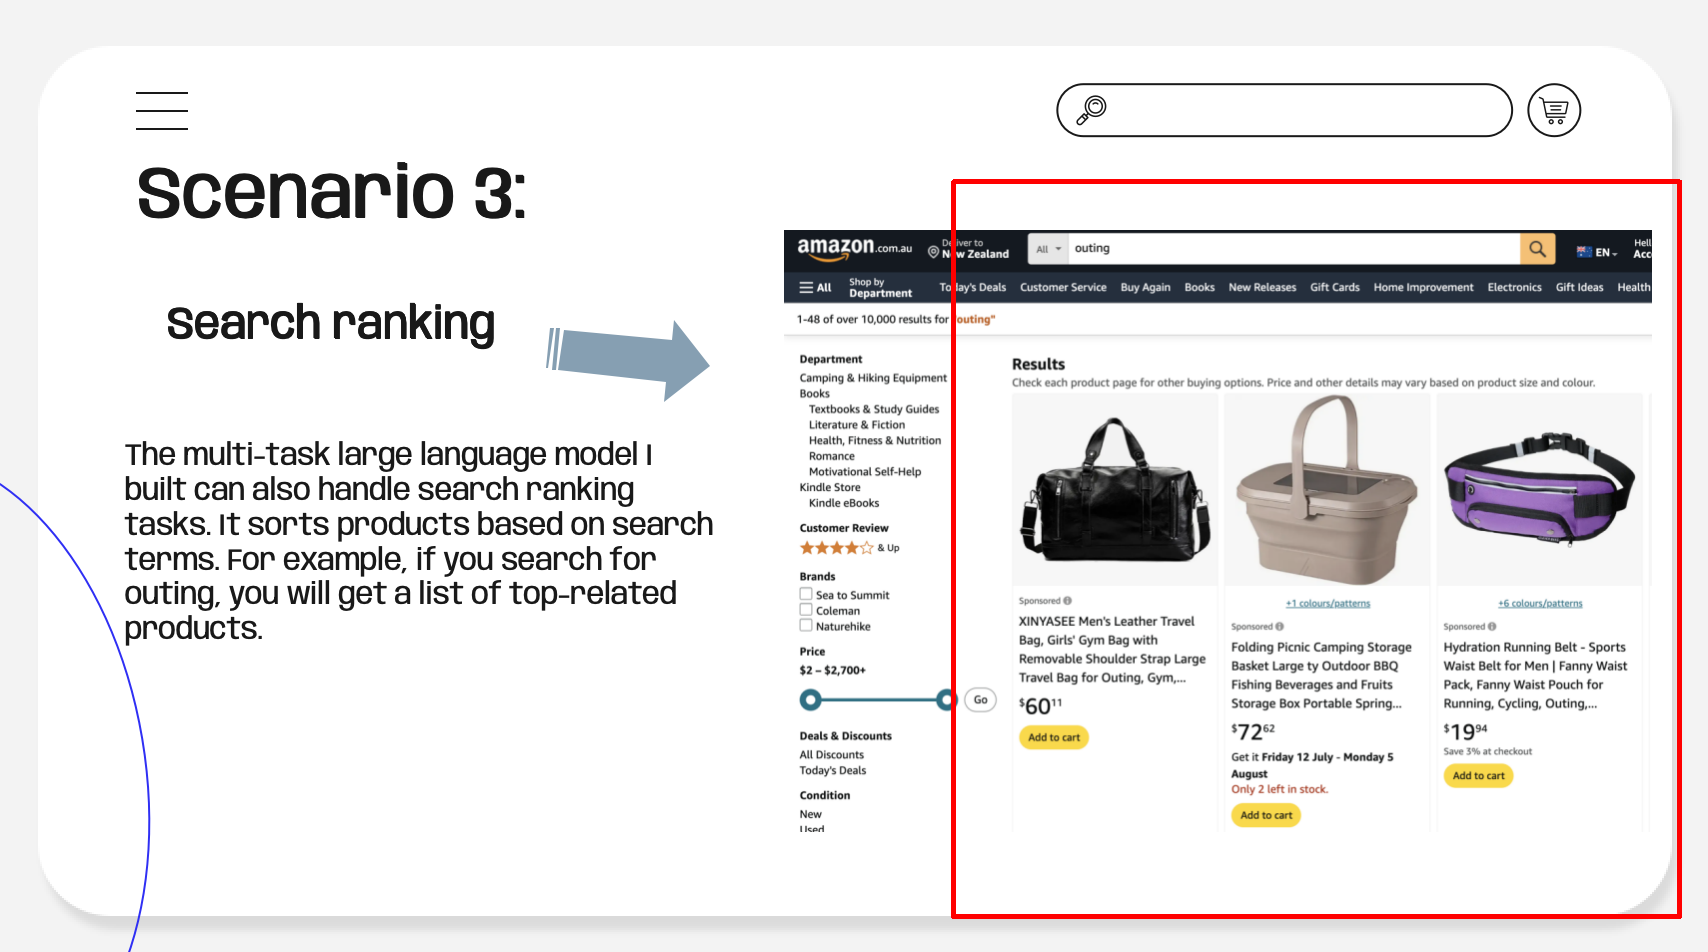

In [8]:
display(Image(filename='./Images/s3.jpg', width = 700, height = 160))

In [9]:
ranking_prompt = "The following numbered list contains 5 products. Please rank the products according to their relevance with the query \'optimus prime jewelry\'. \\nProduct List: \\n1. Handmade Anime Model Kit Q Version Optimus Prime Desktop Jewelry Ornaments H-2020-5-7\\n2. Handmade Anime Model Kit Q Version Optimus Prime Desktop Jewelry Ornaments H-2020-6-22\\n3. Printed Modern Comforter Cover-3 Pieces Optimus Prime Transformers 3D Digital Print Bedding Sets Bedding 3 Piece Duvet Cover Set Full\\n4. TKB Lip Gloss Base | Clear Versagel Base for DIY Lip Gloss, Made in USA 11 oz (2 of 5.5 oz bags) Mineral-Oil-Free ($1.37/oz)\\n5. Puerto Rico - Torn Flag Strong Proud Youth T-Shirt (Red, Small)\\nYou should output a permutation of 1 to 5. There should be a comma separating two numbers. Each product and its number should appear only once in the output. Only respond with the ranking results."
system_prompt = 'You are an intelligent shopping assistant that can rank products based on their relevance to the query.'
get_response(system_prompt, ranking_prompt)

Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


'1,2,3,4,5'

- 1,2,3,4,5 means the index order of products ranked by relevance to the query "optimus prime jewelry" is 1,2,3,4,5.

## Also buy example
- This task is based on the relationship between products and recommends products that users may buy in the future based on the products they have purchased. A potential application scenario is related recommendations after purchase (may also buy).

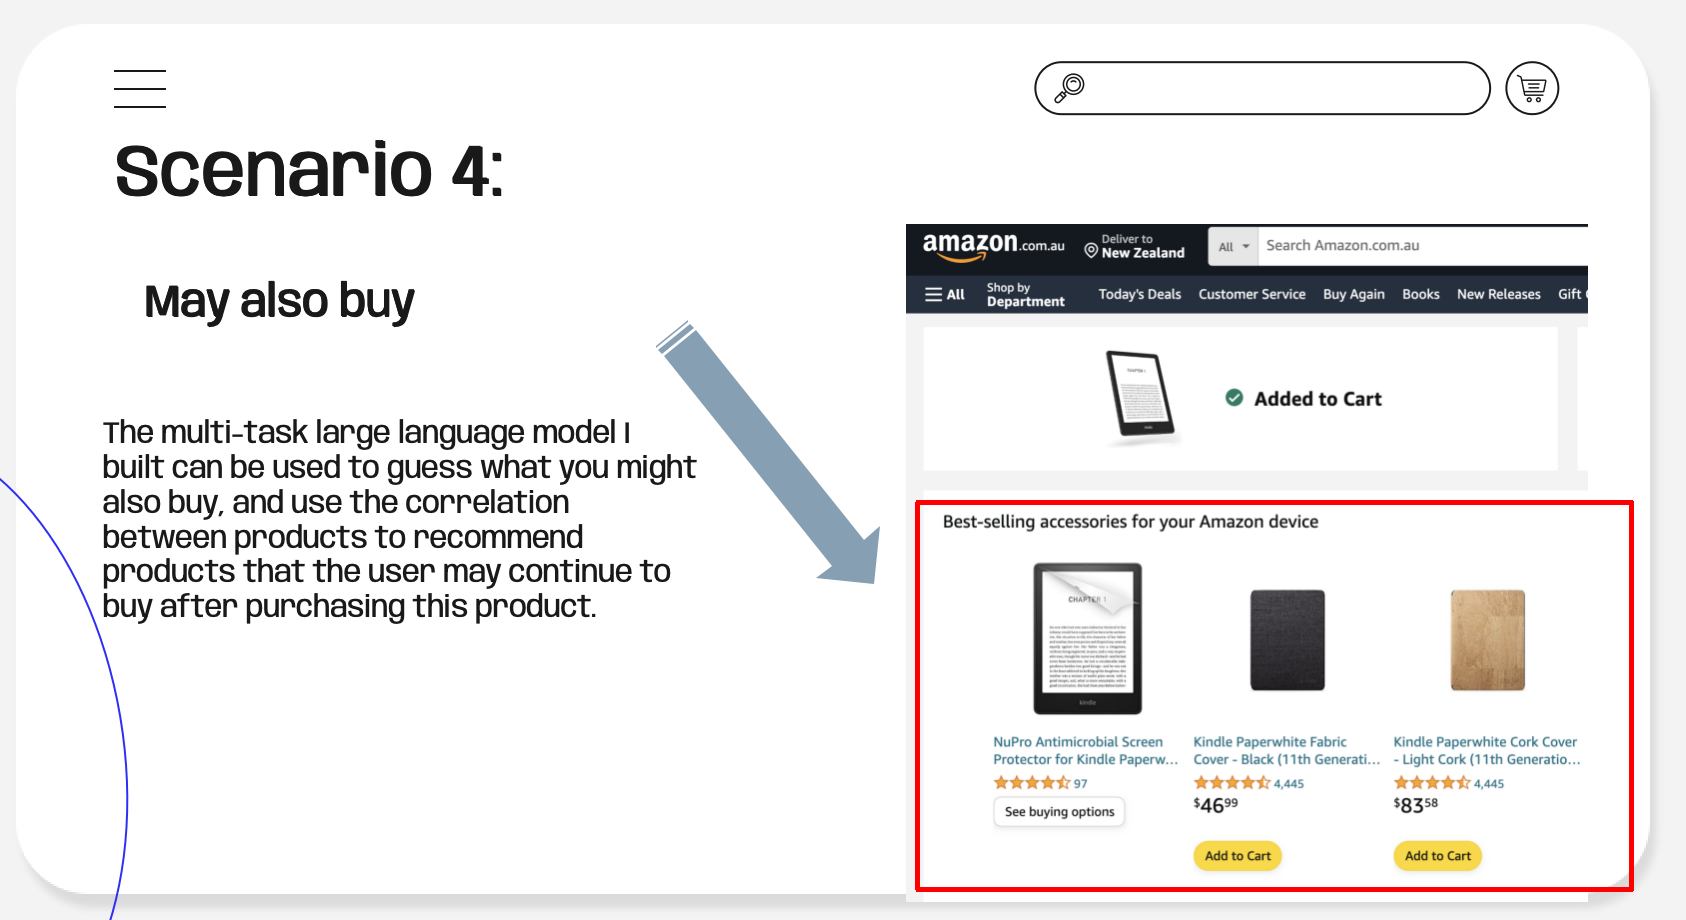

In [10]:
display(Image(filename='./Images/s4.jpg', width = 700, height = 160))

In [11]:
also_buy_prompt = "A user on an online shopping website has just purchased a product 'Steven Harris Mathematics Math Equations Necktie - Red - One Size Neck Tie'. The following numbered list contains 15 products. Please select 3 products from the list that the user may also purchase.\nProduct List: \n1. Under Armour Men`s ColdGear Lite Cushion Boot Socks, 1 Pair\n2. Little Angel Tasha-685E Patent Bow Mary Jane Pump (Toddler\/Little Girl\/Big Girl) - Fuchsia\n3. Men's Solar System Planets Necktie-Black-One Size Neck Tie by\n4. Crocs Women's Malindi Flat\n5. Wrangler Men's Big & Tall Rugged Wear Unlined Denim Jacket\n6. NIKE Sunray Protect 2 (TD) Womens Fashion-Sneakers 943829\n7. Calvin Klein Women's Seductive Comfort Customized Lift Bra with Lace\n8. Steven Harris Mens Smiley Face Necktie - Yellow - One Size Neck Tie\n9. ComputerGear Math Formula Tie Engineer Silk Equations Geek Nerd Teacher Gift\n10. Harley-Davidson Boys Baby Twin Pack Creeper My Daddy Rides a Harley Orange\n11. Liverpool Football Club Official Soccer Gift Mens Crest T-Shirt\n12. SITKA Traverse Beanie Waterfowl One Size Fits All (90002-WL-OSFA)\n13. The Magic Zoo Sterling Silver Snake Chain with Lobster Clasp\n14. Napier\"Classics\" Silver-Tone Round Button Earrings\n15. Tru-Spec Men's Base Layers Series Gen-iii ECWCS Level-2 Bottom\nYou should output 3 numbers that correspond to the selected products. There should be a comma separating every two numbers. Only respond with the results. Do not say any word or explanations.\nOutput: "
system_prompt = 'You are an intelligent shopping assistant that can rank products based on their relevance to the query.'
get_response(system_prompt, also_buy_prompt)

Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.99it/s]


'3,8,9'

- 3,8,9 means that after purchasing the product "Steven Harris Mathematics Math Equations Necktie - Red - One Size Neck Tie", the indexes of the products that may be purchased in the candidate products are 3,8,9.

## Sentiment analysis example
- This task is to perform sentiment analysis on the evaluation based on the user's comments on the product. One potential application scenario is sentiment analysis in the product review area.

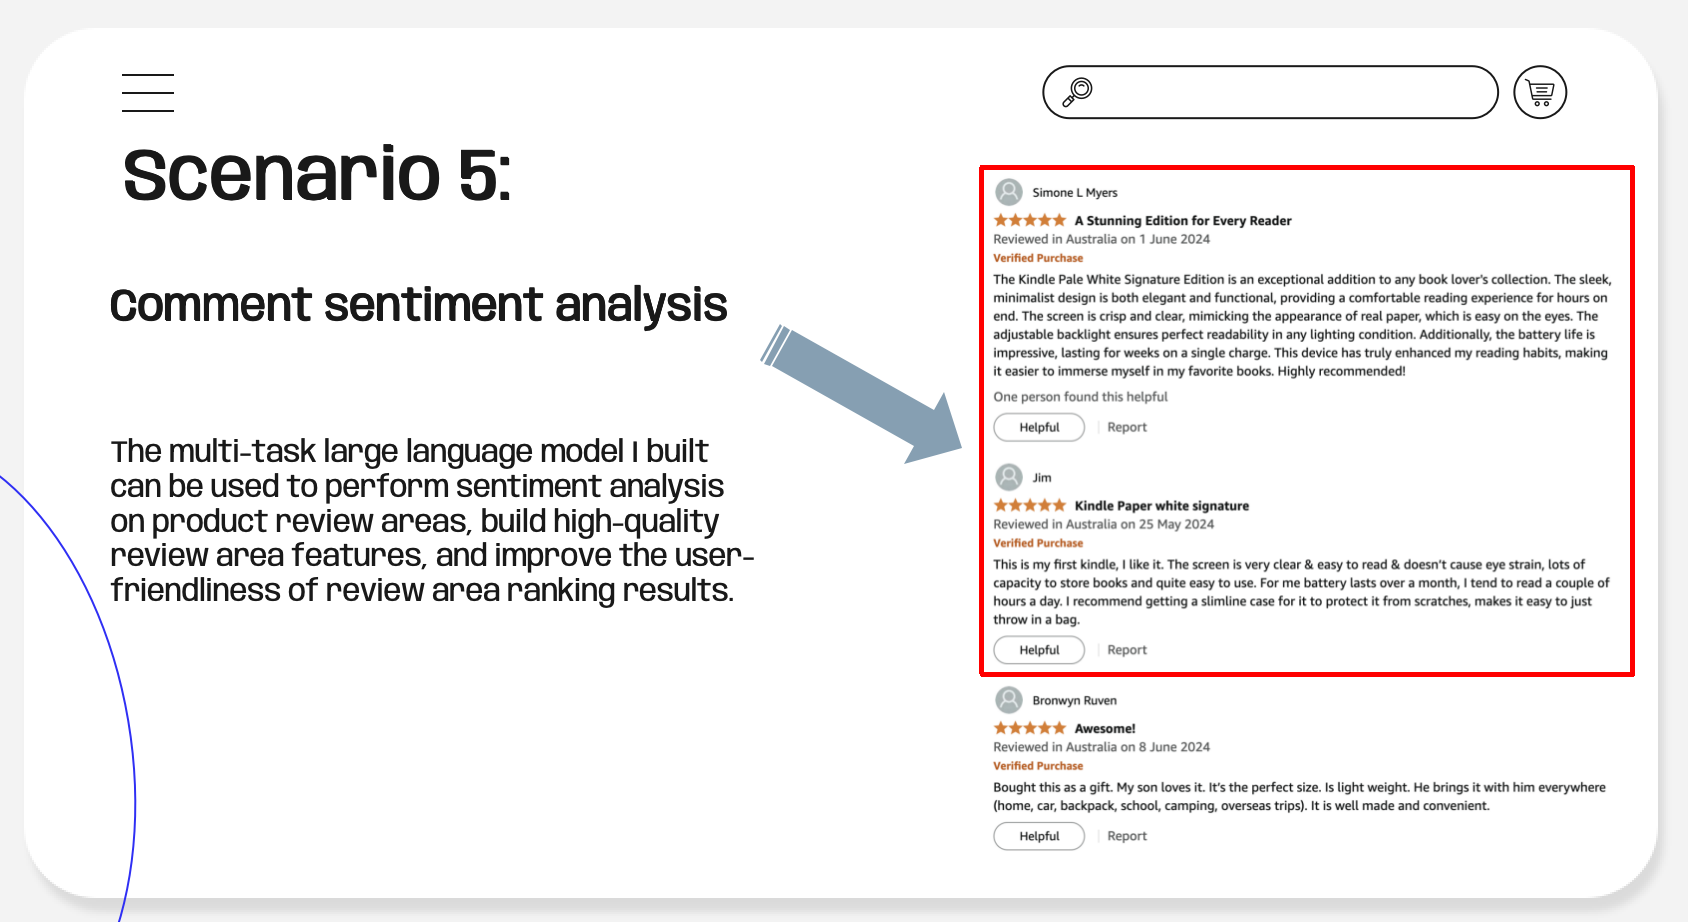

In [12]:
display(Image(filename='./Images/s5.jpg', width = 700, height = 160))

In [13]:
sentiment_prompt = "Instructions: Evaluate the following product review on a scale of 1 to 5, with 1 being very negative and 5 being very positive. \nInput: a review text for a(n) Leotard product\nRuns small and fabric doesn\u2019t stretch\nThis body shaper is way too small even though I bought 2X. It doesn\u2019t stretch at all to be form fitting. I don\u2019t like this product and will never purchase it again.\nOutput:\nAnswer: "
system_prompt = 'You are an intelligent shopping assistant that can rank products based on their relevance to the query.'
get_response(system_prompt, sentiment_prompt)

Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


'1'

## Generation example
- This task generates a title for a product based on the product information. The potential application scenario is tob, generating high-quality titles for the products that sellers upload.

In [14]:
generation_prompt = "A product entitled 'Steadtler Fimo Soft Starter Pack 12 x 57 g Multicolour Blocks' exists on an online shopping website. Generate an adequate title for the product when it appears on a(n) German online shopping website.\nOutput: "
system_prompt = 'You are an intelligent shopping assistant that can rank products based on their relevance to the query.'
get_response(system_prompt, generation_prompt)

Processed prompts: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


'Fimo Soft 57g, 12-Piece Set'